# 13 - 面板数据和固定效应

## 控制你看不到的东西

倾向得分、线性回归和匹配等方法非常擅长控制非随机数据中的混淆现象，但它们依赖于一个关键假设：控制后无混淆

$
(Y_0, Y_1) \perp T | X
$

简而言之，它们要求所有混淆因素都是已知的和可测量的，这样我们才能以它们为条件并使处理尽可能随机。一个主要问题是有时我们根本无法衡量混淆因素。例如，拿一个经典的劳动经济学问题来计算婚姻对男性收入的影响。经济学中众所周知的事实是，已婚男性的收入高于单身男性。但是，尚不清楚这种关系是否是因果关系。可能是受过更多教育的男性更有可能结婚，也更有可能从事高收入工作，这意味着教育是婚姻对收入影响的一个混淆因素。对于这个混杂因素，我们可以衡量研究中人员的教育程度，并对其进行回归控制。但另一个混淆因素可能是好看的外貌。可能是更英俊的男人更有可能结婚，也更有可能获得高薪工作。不幸的是，美丽和智力这类特征类似，这是我们无法很好衡量的东西。

这使我们陷入困境，因为如果我们有无法衡量的混淆因素，我们就有偏差。正如我们之前所见，处理这个问题的一种方法是使用工具变量。但是想出好的工具变量并不是一件容易的事，需要很多的创造力。在这里，让我们看一下利用时间或数据的时间结构的替代方案。

这个想法是使用**面板数据**。当我们**在多个时间段内对同一个人进行观察**，我们就得到了面板数据。面板数据格式在行业中非常常见，比如当对同一用户在多个时间段的行为记录进行记录和保存的时候。我们可以利用面板数据的原因是因为我们可以在干预前后比较同一个单位，看看他们在干预前后的表现如何。在我们深入研究数学之前，让我们看看如何进行直观地理解。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

from linearmodels.panel import PanelOLS


%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

首先，让我们看一下我们在跨时间包含同一单位的多个观察后得到的因果图。 假设我们有这样一种情况，第一次结婚同时导致收入和随后的婚姻状况。 对于第 2 次和第 3 次也是如此。此外，假设所有时间段的美貌都是相同的（这是一个大胆的说法，但如果时间只有几年，这是合理的），它会导致婚姻和收入。

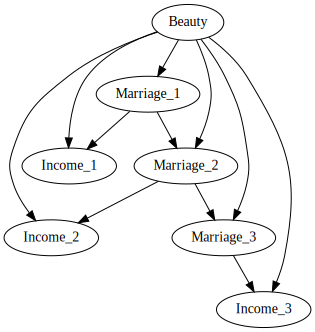

In [2]:
g = gr.Digraph()
g.edge("Marriage_1", "Income_1")
g.edge("Marriage_1", "Marriage_2")
g.edge("Marriage_2", "Income_2")
g.edge("Marriage_2", "Marriage_3")
g.edge("Marriage_3", "Income_3")

g.edge("Beauty", "Marriage_1")
g.edge("Beauty", "Marriage_2")
g.edge("Beauty", "Marriage_3")

g.edge("Beauty", "Income_1")
g.edge("Beauty", "Income_2")
g.edge("Beauty", "Income_3")

g

请记住，我们无法控制外貌多美这个因素，因为我们无法衡量它。 但是我们仍然可以使用面板结构，所以它不再是问题了。 这个想法是，我们可以将美——以及任何其他随时间不变的属性——视为定义一个人的综合要素。 虽然我们不能直接控制它们，但我们可以控制个人本身。

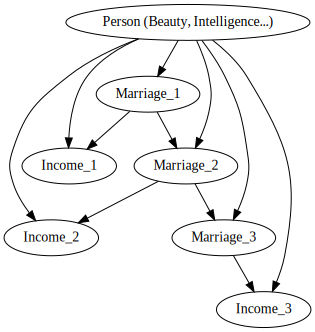

In [3]:
g = gr.Digraph()
g.edge("Marriage_1", "Income_1")
g.edge("Marriage_1", "Marriage_2")
g.edge("Marriage_2", "Income_2")
g.edge("Marriage_2", "Marriage_3")
g.edge("Marriage_3", "Income_3")

g.edge("Person (Beauty, Intelligence...)", "Marriage_1")
g.edge("Person (Beauty, Intelligence...)", "Marriage_2")
g.edge("Person (Beauty, Intelligence...)", "Marriage_3")

g.edge("Person (Beauty, Intelligence...)", "Income_1")
g.edge("Person (Beauty, Intelligence...)", "Income_2")
g.edge("Person (Beauty, Intelligence...)", "Income_3")

g

想想看。我们无法衡量美貌和智力等属性，但我们知道拥有这些属性的人是同一个人。因此，我们可以创建一个表示该人的虚拟变量并将其添加到线性模型中。当我们说我们可以控制人本身时，这就是我们的意思：我们正在添加一个表示该特定人的变量（在本例中为虚拟变量）。在我们的模型中使用这个人来估计婚姻对收入的影响时，回归发现婚姻的影响**同时保持人这个变量固定**。添加这个实体个人对应的虚拟变量就是我们所说的固定效应模型。


## 固定效应

为了方面后面更正式地讲述，让我们首先看一下我们拥有的数据。按照我们的例子，我们将尝试估计婚姻对收入的影响。我们的数据包含多年以来多个个体 (`nr`) 的这两个变量，`married` 和`lwage`。请注意，工资采用对数形式。除此之外，我们还有其他控制措施，例如当年的工作小时数、受教育年限等。

In [4]:
from linearmodels.datasets import wage_panel
data = wage_panel.load()
data.head()

,nr,year,black,...,lwage,expersq,occupation
0,13,1980,0,...,1.197540,1,9
1,13,1981,0,...,1.853060,4,9
2,13,1982,0,...,1.344462,9,9
3,13,1983,0,...,1.433213,16,9
4,13,1984,0,...,1.568125,25,5


通常，固定效应模型定义为

$
y_{it} = \beta X_{it} + \gamma U_i + e_{it}
$

其中 \\(y_{it}\\) 是个体 \\(i\\) 在时间 \\(t\\) 的结果，\\(X_{it}\\) 是个体变量的向量\\(i\\) 在时间 \\(t\\)。 \\(U_i\\) 是单个 \\(i\\) 的一组不可观测值。请注意，这些不可观测值随着时间的推移是不变的，因此缺少时间下标。最后，\\(e_{it}\\) 是错误项。对于教育示例，\\(y_{it}\\) 是对数工资，\\(X_{it}\\) 是随时间变化的可观察变量，例如婚姻和经验，\\(U_i\\)是每个人没有观察到但不变的变量，例如美丽和智力。


现在，请记住我说过使用具有固定效果模型的面板数据就像为实体添加虚拟对象一样简单。这是真的，但在实践中，我们实际上并没有这样做。想象一个我们有 100 万客户的数据集。如果我们为它们中的每一个添加一个 dummy，我们最终会得到 100 万列，这可能不是一个好主意。相反，我们使用将线性回归划分为 2 个独立模型的技巧。我们以前见过这个，但现在是回顾它的好时机。假设您有一个线性回归模型，其中包含一组特征 \\(X_1\\) 和另一组特征 \\(X_2\\)。

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

其中 \\(X_1\\) 和 \\(X_1\\) 是特征矩阵（每个特征一行，每个观察一列）和 \\(\hat{\beta_1}\\) 和 \\(\hat{ \beta_2}\\) 是行向量。您可以通过执行获得完全相同的 \\(\hat{\beta_1}\\) 参数

1. 在第二组特征 \\(\hat{y^*} = \hat{\gamma_1} X_2\\) 上回归结果 \\(y\\)
2. 在第二个 \\(\hat{X_1} = \hat{\gamma_2} X_2\\) 上回归第一组特征
3. 得到残差 \\(\tilde{X}_1 = X_1 - \hat{X_1}\\) 和 \\(\tilde{y}_1 = y_1 - \hat{y^*}\\)
4. 将结果的残差回归到特征残差 \\(\hat{y} = \hat{\beta_1} \tilde{X}_1\\)

最后一次回归的参数将与使用所有特征运行回归完全相同。但这究竟对我们有什么帮助呢？好吧，我们可以将带有实体假人的模型的估计分解为 2。首先，我们使用假人来预测结果和特征。这些是上面的步骤 1 和 2。

现在，还记得在虚拟变量上运行回归是如何像估计该虚拟变量的平均值一样简单吗？如果你不这样做，让我们用我们的数据来证明这是真的。让我们运行一个模型，我们将工资预测为虚拟年份的函数。

In [5]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


请注意该模型如何预测 1980 年的平均收入为 1.3935，1981 年的平均收入为 1.5129 (1.3935+0.1194) 等等。 现在，如果我们按年份计算平均值，我们会得到完全相同的结果。 （请记住，基准年 1980 是截距。因此，您必须将截距添加到其他年份的参数中才能获得该年的平均`lwage`）。

In [6]:
data.groupby("year")["lwage"].mean()

year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

这意味着，如果我们得到面板中每个人的平均值，我们基本上是在对其他变量进行个体虚拟回归。这激发了以下估计过程：

1. 通过减去个人的平均值来创建时间贬损变量：
$\ddot{Y}_{it} = Y_{it} - \bar{Y}_i$
$\ddot{X}_{it} = X_{it} - \bar{X}_i$

2. 在 $\ddot{X}_{it}$ 上回归 $\ddot{Y}_{it}$


请注意，当我们这样做时，未观察到的 \\(U_i\\) 消失了。由于 \\(U_i\\) 在时间上是恒定的，所以我们有 \\(\bar{U_i}=U_i\\)。如果我们有以下两个方程组

$$
\开始{对齐}
Y_{it} & = \beta X_{it} + \gamma U_i + e_{it} \\
\bar{Y}_{i} & = \beta \bar{X}_{it} + \gamma \bar{U}_i + \bar{e}_{it} \\
\结束{对齐}
$$

我们从另一个中减去一个，我们得到

$$
\开始{对齐}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + ( e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{它}） \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\结束{对齐}
$$

它消除了所有未观察到的随时间不变的事物。老实说，不仅未观察到的变量消失了。这发生在所有时间不变的变量上。因此，您不能包含任何随时间保持不变的变量，因为它们将是虚拟变量的线性组合，并且模型不会运行。

![img](./data/img/fixed-effects/demeaned.png)

要检查哪些变量是这些变量，我们可以按个体对数据进行分组并获得标准差的总和。如果它为零，则意味着对于任何个人来说，变量都不会随时间变化。

In [7]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

对于我们的数据，我们需要删除实体假人，`black`和`hisp`，因为它们对于个人来说是恒定的。 此外，我们需要取消教育。 我们也不会使用职业，因为这可能会调节婚姻对工资的影响（可能是单身男性能够承担更多时间要求更高的职位）。 选择了我们将使用的功能后，是时候估计这个模型了。

要运行我们的固定效应模型，首先，让我们获取平均数据。 我们可以通过按个人对所有内容进行分组并取平均值来实现这一点。

In [8]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


为了将数据围绕均值标准化（demean），我们需要将原始数据的索引设置为个体标识符，`nr`。 然后，我们可以简单地从一个数据集中减去对应的数据均值的数据集。

In [9]:
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


In [10]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.021e-17,0.005,-1.78e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


如果我们相信固定效应消除了所有遗漏的变量偏差，那么这个模型告诉我们婚姻使男人的工资增加了 11%。 这个结果非常显着。 这里的一个细节是，对于固定效应模型，需要对标准误差进行聚类。 因此，我们可以使用库 `linearmodels` 并将参数 `cluster_entity` 设置为 True，而不是手动进行所有估计（这只是出于教学原因）。

In [11]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247


请注意参数估计值与我们使用时间贬值数据得到的参数估计值是如何相同的。 唯一的区别是标准误差有点大。 现在，将其与不考虑数据时间结构的简单 OLS 模型进行比较。 对于这个模型，我们添加了及时不变的变量。

In [12]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


这个模型是说婚姻使男人的工资增加了 14%。 比我们在固定效应模型中发现的效应要大一些。 这表明由于固定的个体因素（如智力和美貌）没有被添加到模型中，结果存在一些省略变量偏差。

## 固定效应的可视化

为了扩展我们对固定效应模型如何工作的直觉，让我们稍微转向另一个例子。 假设您在一家大型科技公司工作，并且您想估计广告牌营销活动对应用内购买的影响。 当您查看过去的数据时，您会发现营销部门倾向于花费更多的钱在购买水平较低的城市放置广告牌。 这是有道理的吧？ 如果销售额猛增，他们就不需要做很多广告了。 如果您在此数据上运行回归模型，看起来营销成本较高会导致应用内购买减少，但这只是因为营销投资偏向于低支出地区。

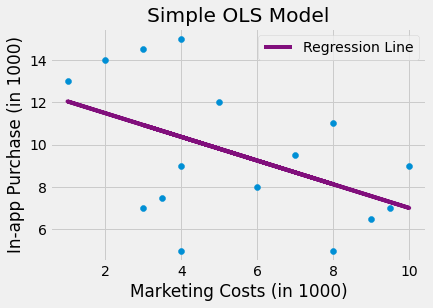

In [13]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

对因果推理了解很多后，您决定运行一个固定效应模型，将城市标识作为虚拟变量添加到您的模型中。 固定效应模型控制了在时间上保持不变的城市特定特征，因此如果一个城市对您的产品不太开放，它将捕捉到这一点。 当您运行该模型时，您最终可以看到更多的营销成本会导致更高的应用内购买。

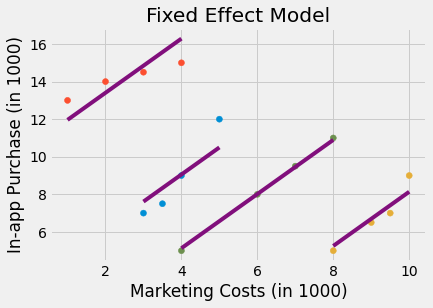

In [14]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

花一点时间来理解上面的图片到底告诉你固定效果在做什么。请注意，固定效应模型**对每个城市拟合一条回归线**。还要注意拟合的回归线是平行的。线的斜率是营销成本对应用内购买的影响。所以**固定效应是假设因果效应在所有实体中都是常数**，在我们的例子中，实体是城市。这可能是一个弱点或一个优势，取决于你的目的。如果您的兴趣是对每个城市找到其包含的因果关系，那么这是一个弱点。由于 FE 模型假设这种效应在实体之间是一样的，因此您不会发现因果效应有任何差异。然而，如果你想找到营销对应用内购买的整体影响，面板结构的数据是一个非常有用的途径来使用固定效应模型进行探索。

## 时间效应

就像我们在个人颗粒度做固定效果一样，我们可以为时间颗粒度设计一个固定效果。如果为控制固定的个体特征而为每个个体添加一个虚拟变量，则添加一个时间颗粒度的虚拟变量将控制每个时间段内固定的变量，但不同时间之间是可以变化的。这种变量的一个例子是通货膨胀。价格和工资往往会随着时间的推移而上涨，但每个时间段的通货膨胀对于所有实体来说都是相同的。举一个更具体的例子，假设婚姻随着时间的推移而增加。如果工资和婚姻比例也随时间变化，我们就有时间作为一个混淆因素。由于通货膨胀也使工资随着时间的推移而增加，我们在婚姻和工资之间看到的一些正相关可能仅仅是因为两者都随着时间的推移而增加。为了纠正这一点，我们可以为每个时间段添加一个虚拟变量。在“线性模型”中，这就像在我们的公式中添加“TimeEffects”并将“cluster_time”设置为 true 一样简单。

In [15]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174


在这个新模型中，婚姻对工资的影响从“0.1147”明显地下降到“0.0476”。尽管如此，这一结果在 99% 的水平上仍然是显著的，因此男人仍然可以预期婚姻会让收入增加。

## 当面板数据对您没有帮助时

使用面板数据和固定效应模型是一种非常强大的因果推理工具。当您没有随机数据也没有好的仪器时，固定效应与非实验数据的因果推断一样令人信服。不过，值得一提的是，它并不是灵丹妙药。在某些情况下，即使面板数据也无济于事。

最明显的一个情况是当您有随时间变化的混淆因素时。固定效应只能消除由于每个实体不变的属性带来的偏差。例如，假设您可以通过阅读书籍和食用大量优质脂肪来提高您的智力水平。同时这又会让你得到一份更高薪的工作和一个妻子。由于智力这个无法测量的混淆因素，固定效应将无法消除其带来的偏差，因为在这个例子中，智力是随时间变化的。

![img](./data/img/fixed-effects/time-travel.png)

固定效应失败的另一个不太明显的情况是当你有 **逆向因果（reversed causality）** 时。例如，假设不是婚姻让你赚得更多，而是当你收入越多，你结婚的机会就越多。在这种情况下，它们似乎具有正相关性，但是收入在线，是原因。二者都会随着时间在同一个方向发生变化，因此固定效应无法控制这一点。


## 关键思想

在这里，我们看到了如何使用面板数据，即我们在多个时间段内对同一个人进行多次测量的数据。在这种情况下，我们可以使用控制实体间差异的固定效应模型，保持所有个体不随时间变化的属性固定。这是一种强大且非常令人信服的控制混淆的方法，它可以得到与非随机数据一样好的结果。

最后，我们看到 FE 并不是万能的。我们看到了两种不起作用的情况：当我们有反向因果关系时，以及当不可测量的混淆因素随时间变化时。